# Task-1 
## Movie Genre Classification
### Problem Statement
Create a machine learning model that can predict the genre of a
movie based on its plot summary or other textual information. You
can use techniques like TF-IDF or word embeddings with classifiers
such as Naive Bayes, Logistic Regression, or Support Vector
Machines.

## Importing important libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
import spacy
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
import en_core_web_lg
nlp = en_core_web_lg.load()

import warnings
warnings.filterwarnings('ignore')

## Importing Dataset

In [2]:
data = pd.read_csv('./Genre Classification Dataset/train_data.txt', header=None, sep=' ::: ')
data.drop([0],axis=1,inplace=True)
data.columns = ['TITLE','GENRE','DESCRIPTION']
data.head()

,TITLE,GENRE,DESCRIPTION
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


## Data Preprocessing

In [9]:
" ".join(data['TITLE'][3].split()[:-1])

'The Secret Sin'

In [10]:
def remove_year(title):
    clean_title = title.split()[:-1]
    return " ".join(clean_title)

data['TITLE'] = data['TITLE'].apply(remove_year)
data.head()

,TITLE,GENRE,DESCRIPTION
0,Oscar et la dame rose,drama,Listening in to a conversation between his doc...
1,Cupid,thriller,A brother and sister with a past incestuous re...
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fiel...
3,The Secret Sin,drama,To help their unemployed father make ends meet...
4,The Unrecovered,drama,The film's title refers not only to the un-rec...


In [13]:
data['TITLE'] = data['TITLE'].apply(lambda x: x.lower())
data['DESCRIPTION'] = data['DESCRIPTION'].apply(lambda x: x.lower())
data.head()

,TITLE,GENRE,DESCRIPTION
0,oscar et la dame rose,drama,listening in to a conversation between his doc...
1,cupid,thriller,a brother and sister with a past incestuous re...
2,"young, wild and wonderful",adult,as the bus empties the students for their fiel...
3,the secret sin,drama,to help their unemployed father make ends meet...
4,the unrecovered,drama,the film's title refers not only to the un-rec...


In [14]:
unique_genre = data['GENRE'].unique()
unique_genre.sort()
print(unique_genre)
print(len(unique_genre))

['action' 'adult' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy' 'game-show' 'history' 'horror'
 'music' 'musical' 'mystery' 'news' 'reality-tv' 'romance' 'sci-fi'
 'short' 'sport' 'talk-show' 'thriller' 'war' 'western']
27


In [15]:
genre_mapper = {}
for i, genre in enumerate(unique_genre):
    genre_mapper[genre] = i

print(genre_mapper)

{'action': 0, 'adult': 1, 'adventure': 2, 'animation': 3, 'biography': 4, 'comedy': 5, 'crime': 6, 'documentary': 7, 'drama': 8, 'family': 9, 'fantasy': 10, 'game-show': 11, 'history': 12, 'horror': 13, 'music': 14, 'musical': 15, 'mystery': 16, 'news': 17, 'reality-tv': 18, 'romance': 19, 'sci-fi': 20, 'short': 21, 'sport': 22, 'talk-show': 23, 'thriller': 24, 'war': 25, 'western': 26}


In [16]:
data['LABELS'] = data['GENRE'].map(genre_mapper)
data.head()

,TITLE,GENRE,DESCRIPTION,LABELS
0,oscar et la dame rose,drama,listening in to a conversation between his doc...,8
1,cupid,thriller,a brother and sister with a past incestuous re...,24
2,"young, wild and wonderful",adult,as the bus empties the students for their fiel...,1
3,the secret sin,drama,to help their unemployed father make ends meet...,8
4,the unrecovered,drama,the film's title refers not only to the un-rec...,8


In [17]:
data['GENRE'].value_counts()

drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: GENRE, dtype: int64

[Text(0, 0, 'drama'),
 Text(1, 0, 'thriller'),
 Text(2, 0, 'adult'),
 Text(3, 0, 'documentary'),
 Text(4, 0, 'comedy'),
 Text(5, 0, 'crime'),
 Text(6, 0, 'reality-tv'),
 Text(7, 0, 'horror'),
 Text(8, 0, 'sport'),
 Text(9, 0, 'animation'),
 Text(10, 0, 'action'),
 Text(11, 0, 'fantasy'),
 Text(12, 0, 'short'),
 Text(13, 0, 'sci-fi'),
 Text(14, 0, 'music'),
 Text(15, 0, 'adventure'),
 Text(16, 0, 'talk-show'),
 Text(17, 0, 'western'),
 Text(18, 0, 'family'),
 Text(19, 0, 'mystery'),
 Text(20, 0, 'history'),
 Text(21, 0, 'news'),
 Text(22, 0, 'biography'),
 Text(23, 0, 'romance'),
 Text(24, 0, 'game-show'),
 Text(25, 0, 'musical'),
 Text(26, 0, 'war')]

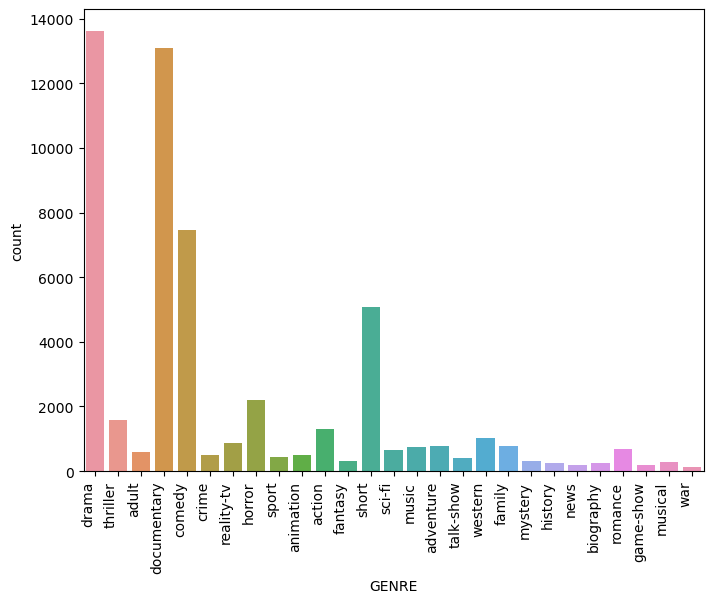

In [19]:
fig = plt.figure(figsize=(8,6))
count_plot = sns.countplot(x='GENRE',data = data)
count_plot.set_xticklabels(count_plot.get_xticklabels(), rotation=90, ha="right")

## Cleaning the data

In [20]:
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

raw_length = word_length(data['DESCRIPTION'])

In [21]:
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

raw_unique_length = unique_word_length(data['DESCRIPTION'])

In [28]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells'] 
stopwords_list += [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = ' '.join(text)
    text = nlp(text)
    text = [w.lemma_ for w in text]
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

In [29]:
data["DESCRIPTION"][5]

'quality control consists of a series of 16mm single take shots filmed in the summer of 2010,over a two day period, in a dry cleaners facility in pritchard, alabama, near mobile, quality control exhibits the acts as well the conditions around labor and showcases, in everson\'s words "the fine folks of alabama producing a superior product." it is similar stylistically, in form and rhythm, to certain scenarios in everson\'s award-winning and critically acclaimed previous films, including erie (iffr 2010) and in thematic concerns to several other short form works which follow the daily, quotidian tasks of workers in rest and in motion, and is an oblique sequel, ten years hence, to everson\'s creative capital granted project a week in the hole (2001), which focused on an employee\'s adjustment to materials, time, space and personnel. quality control consists of a series of 16mm single take shots, filmed over a two day period in the summer of 2010, in a dry cleaners facility in pritchard, a

In [31]:
new_df = data.copy(deep = True)
new_df['DESCRIPTION'] = new_df['DESCRIPTION'].map(lambda x : clean_text(x))
new_df['DESCRIPTION'][5]

'quality control consist series mm single take shot film summer day period dry cleaner facility pritchard alabama near mobile quality control exhibit act well condition around labor showcase everson word fine folk alabama produce superior product similar stylistically form rhythm certain scenario everson award win critically acclaim previous film include erie iffr thematic concern several short form work follow daily quotidian task worker rest motion oblique sequel ten year hence everson creative capital grant project week hole focus employee adjustment material time space personnel quality control consist series mm single take shot film day period summer dry cleaner facility pritchard alabama near mobile quality control exhibit act well condition around labor similar stylistically form rhythm certain scenario everson award win critically acclaim previous film include erie iffr thematic concern several short form work follow daily quotidian task worker rest motion include factory routi

In [32]:
new_df.to_pickle('new_df.pkl')

In [33]:
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

clean_length = word_length(new_df['DESCRIPTION'])

In [34]:
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

clean_unique_length = unique_word_length(new_df["DESCRIPTION"])

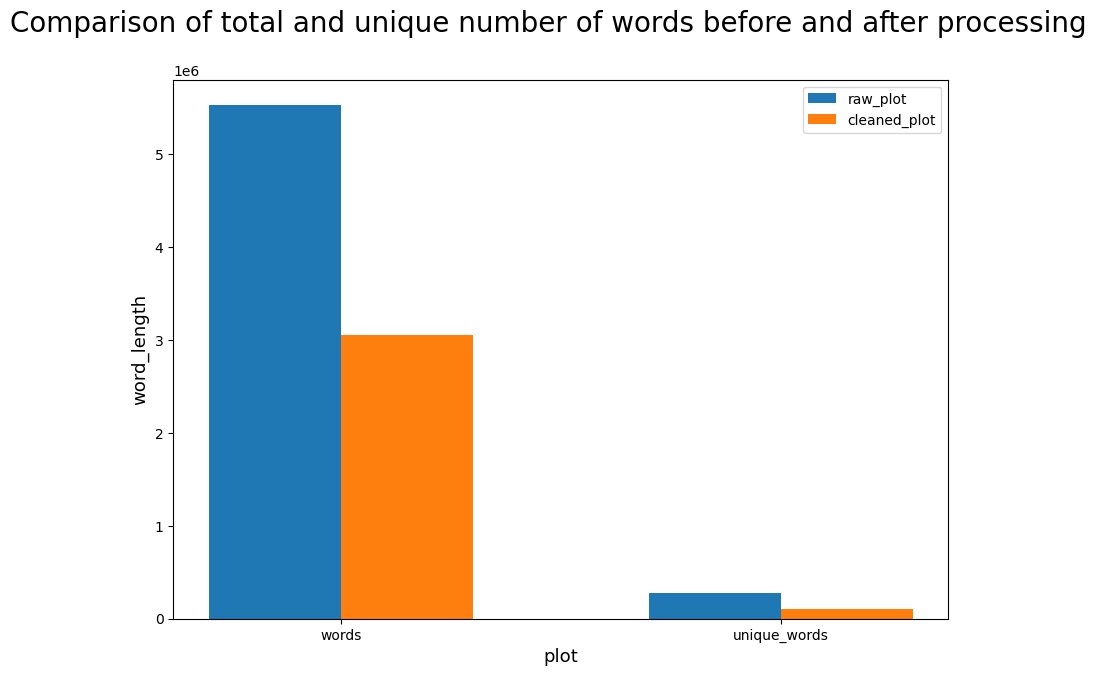

In [35]:
plot_length = [[raw_length, clean_length], [raw_unique_length, clean_unique_length]]
length_df = pd.DataFrame(plot_length, columns = ['num_of_words', 'num_of_unique_words'])
length_df['index'] = ['raw_plot', 'cleaned_plot']

y1 = length_df['num_of_words']
y2 = length_df['num_of_unique_words']

plt.figure(figsize=(10,7))
ind = np.arange(2)

width = 0.3       

plt.bar(ind, y1, width, label='raw_plot')
plt.bar(ind + width, y2, width, label='cleaned_plot')

plt.xlabel('plot', size = 13)
plt.ylabel('word_length', size = 13)
plt.suptitle('Comparison of total and unique number of words before and after processing', size = 20)
plt.xticks(ind + width / 2, ('words', 'unique_words'))
plt.legend(loc='best')
plt.show()
fig.savefig('./images/totalvsuniquewords.png')

In [36]:
length_df

,num_of_words,num_of_unique_words,index
0,5524755,3049690,raw_plot
1,270262,106020,cleaned_plot


## Distribution of words in plot and movie title for each genre

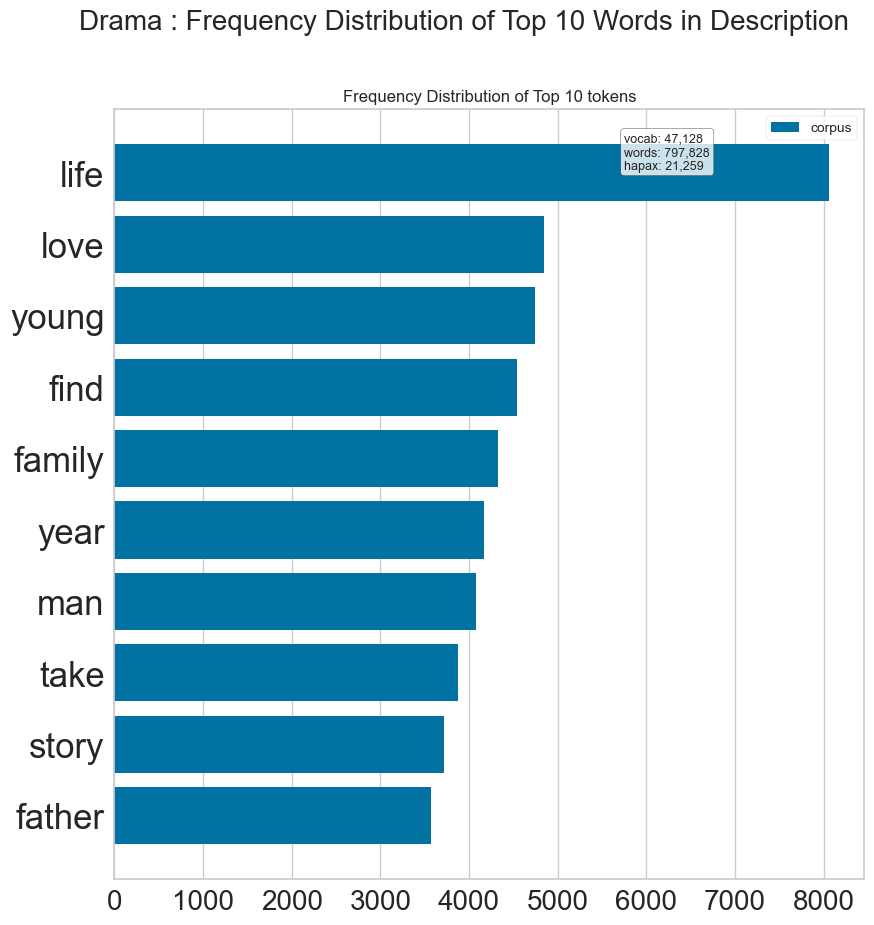

In [49]:
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

drama_plot = new_df.loc[new_df['LABELS'] == 8, ['DESCRIPTION', 'TITLE']]
drama_plotlist = [x for x in drama_plot['DESCRIPTION'].str.split()]
drama_plotlist = list(itertools.chain(*drama_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(drama_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Drama : Frequency Distribution of Top 10 Words in Description', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryfordramagenre.png')

In [45]:
drama_plotlist

['listen',
 'conversation',
 'doctor',
 'parent',
 'year',
 'old',
 'oscar',
 'learn',
 'nobody',
 'courage',
 'tell',
 'week',
 'live',
 'furious',
 'refuse',
 'speak',
 'anyone',
 'except',
 'straight',
 'talking',
 'rise',
 'lady',
 'pink',
 'meet',
 'hospital',
 'stair',
 'christmas',
 'approach',
 'rise',
 'use',
 'fantastical',
 'experience',
 'professional',
 'wrestler',
 'imagination',
 'wit',
 'charm',
 'allow',
 'oscar',
 'live',
 'life',
 'love',
 'full',
 'company',
 'friend',
 'pop',
 'corn',
 'einstein',
 'bacon',
 'childhood',
 'sweetheart',
 'peggy',
 'blue',
 'help',
 'unemployed',
 'father',
 'make',
 'end',
 'meet',
 'edith',
 'twin',
 'sister',
 'grace',
 'work',
 'seamstresse',
 'invalid',
 'grace',
 'fall',
 'prey',
 'temptation',
 'chinatown',
 'opium',
 'become',
 'addict',
 'condition',
 'worsen',
 'misguided',
 'physician',
 'prescribe',
 'morphine',
 'ease',
 'pain',
 'father',
 'strike',
 'oil',
 'family',
 'enjoy',
 'new',
 'prosperity',
 'sister',
 'meet',

## Identifying Important Words of a Particular Genre

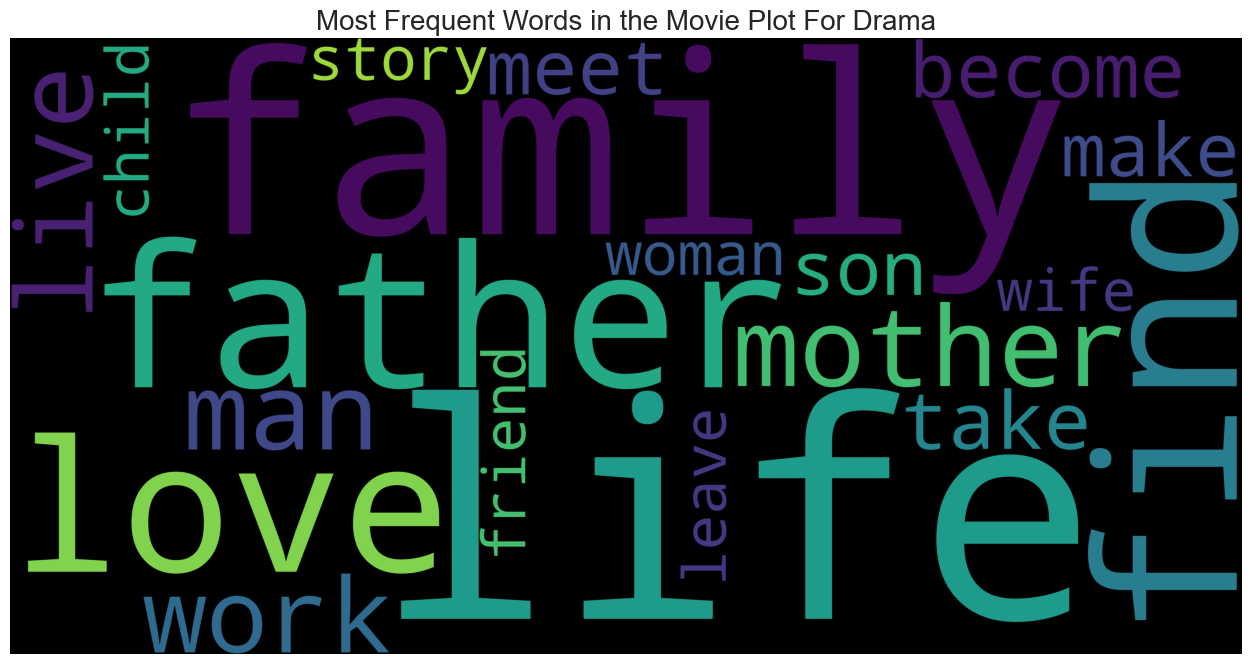

In [46]:
from wordcloud import WordCloud, STOPWORDS

plot_corpus = ' '.join(drama_plotlist)
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words = 20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Drama', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudDrama.png');

In [47]:
drama_titlelist = [x for x in drama_plot['TITLE'].str.split()]
drama_titlelist = list(itertools.chain(*drama_titlelist))

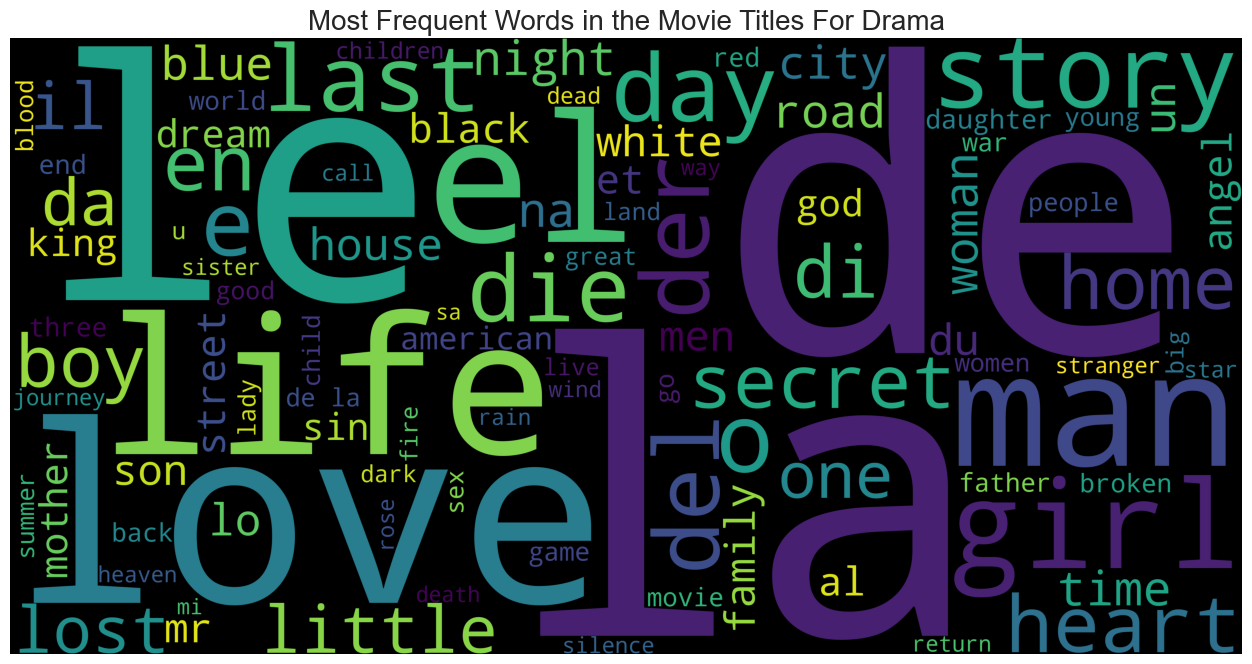

In [48]:
title_corpus = ' '.join(drama_titlelist)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Drama', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudDrama.png');

## Modelling

In [51]:
from sklearn.model_selection import train_test_split
X = new_df['DESCRIPTION']
y = new_df['LABELS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40660,) (13554,) (40660,) (13554,)


## First simple Model using Dummy Classifier

In [53]:
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV

dummy_grid = {
    'strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant']
}
dummy = DummyClassifier( random_state = 42)
dummy_gs = GridSearchCV(dummy, param_grid = dummy_grid, cv = 5)
dummy_gs.fit(X_train, y_train)
print(dummy_gs.best_score_)

0.2511067388096409


## Using TfidfVectorizer on the independent variable and testing out the Multinomial Naive Bayes Model and Decision Tree

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (1,1), max_df=.85, min_df=15, lowercase=False)
tfidf_Xtr = vectorizer.fit_transform(X_train)

#### Grid Search with Multinomial Naive Bayes

In [57]:
from sklearn.naive_bayes import MultinomialNB
model_resultstfidf = {}
mnb_grid = {
    'alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'fit_prior' : [True, False],
    'class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}
mnb = MultinomialNB()
mnb_tfidf_gs = GridSearchCV(mnb, param_grid = mnb_grid, cv = 5)
mnb_tfidf_gs.fit(tfidf_Xtr, y_train)
print(mnb_tfidf_gs.best_score_)

model_resultstfidf['Multinomial Bayes'] = mnb_tfidf_gs.best_score_

0.5539596655189376



#### Grid Search with Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

dt_clf = DecisionTreeClassifier (random_state = 42)
gs_tfidf_tree = GridSearchCV(dt_clf, param_grid = grid, cv = 5)
gs_tfidf_tree.fit(tfidf_Xtr, y_train)

print(gs_tfidf_tree.best_score_)
model_resultstfidf['Decision Tree'] = gs_tfidf_tree.best_score_

0.38607968519429414


### Using Count Vectorizer on the independent variable with Multinomial Naive Bayes Model and Decision Tree

In [68]:
countvec = CountVectorizer(ngram_range = (1,3), max_features = 30000)
vec_Xtr = countvec.fit_transform(X_train)

### Grid Search with Multinomial Naive Bayes

In [69]:
model_results_cvec = {}
mnb_grid = {
    'alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'fit_prior' : [True, False],
    'class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}
mnb = MultinomialNB()
mnb_cvec_gs = GridSearchCV(mnb, param_grid = mnb_grid, cv = 5)
mnb_cvec_gs.fit(vec_Xtr, y_train)
print(mnb_cvec_gs.best_score_)
model_results_cvec['Multinomial Bayes'] = mnb_cvec_gs.best_score_

0.5694294146581407


### Grid Search with Decision Tree

In [70]:
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

dt_clf = DecisionTreeClassifier (random_state = 42)
gs_cvec_tree = GridSearchCV(dt_clf, param_grid = grid, cv = 5)
gs_cvec_tree.fit(vec_Xtr, y_train)

print(gs_cvec_tree.best_score_)
model_results_cvec['Decision Tree'] = gs_cvec_tree.best_score_

0.3876045253320216


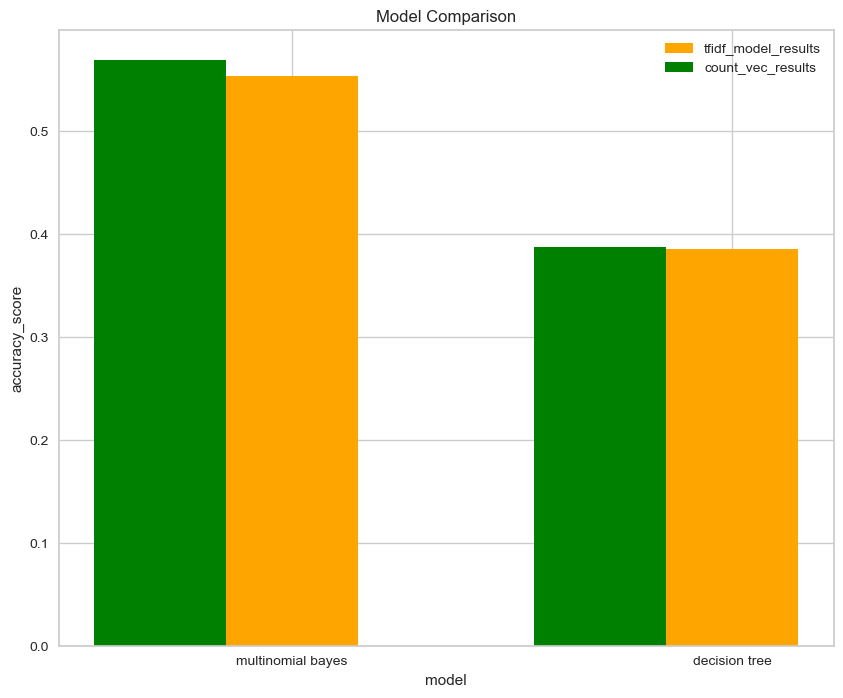

In [76]:
tfidf_model_results = pd.DataFrame(model_resultstfidf.items(), columns=['model', 'accuracy_score'])
count_vec_results = pd.DataFrame(model_results_cvec.items(), columns=['model', 'accuracy_score'])

y1 = tfidf_model_results['accuracy_score']
y2 = count_vec_results['accuracy_score']

fig, ax = plt.subplots(figsize = (10,8))
ind = np.arange(len(tfidf_model_results))

width = 0.3  
plt.bar(ind, y1, width, color = 'orange')
plt.bar(ind - width, y2, width,color = 'green')

plt.title('Model Comparison')
plt.xlabel('model')
plt.ylabel('accuracy_score')
plt.xticks(np.arange(2), ['multinomial bayes', 'decision tree'])
plt.legend(['tfidf_model_results', 'count_vec_results'])
fig.savefig('./images/modelcomparisonplot.png')

In [80]:
import dataframe_image as dfi
model_scores = pd.merge(tfidf_model_results, count_vec_results, how = 'left', on = 'model')
model_scores = model_scores.rename(columns = {'accuracy_score_x':'tfidf_score', 'accuracy_score_y':'count_vec_score'})
dfi.export(model_scores, './images/model_scores.png')